In [1]:
import sys,os, re, itertools, datetime

import numpy as np
import pandas as pd
import nltk
import scipy
import statsmodels

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')

%matplotlib inline

# # pandas styl dplyr
# from dplython import (DplyFrame, X, diamonds, select, sift, sample_n,
#     sample_frac, head, arrange, mutate, group_by, summarize, DelayFunction)

from ggplot import *

C:\Anaconda3\envs\py35\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Anaconda3\envs\py35\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Anaconda3\envs\py35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%load_ext watermark

%watermark -u -n -t -z -v -m -p scipy,pandas,numpy,sklearn,nltk

last updated: Tue Oct 31 2017 15:25:29 China Standard Time

CPython 3.5.4
IPython 6.1.0

scipy 0.19.1
pandas 0.20.3
numpy 1.13.1
sklearn 0.19.0
nltk 3.2.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Loading BokehJS ...


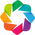

In [3]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap

from bokeh.io import output_notebook, show
output_notebook()

import holoviews as hv
hv.extension('bokeh')

In [4]:
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

init_notebook_mode(connected= True)

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 80
pd.options.display.precision = 4
pd.options.display.max_rows = 999

## Load Data File

https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3

##### San Francisco Data API, powered by Socrata
https://dev.socrata.com/foundry/data.sfgov.org/enhu-st7v

##### API Docs
https://dev.socrata.com/docs/row-identifiers.html

##### sodapy
https://github.com/socrata/sodapy

In [6]:
DATA_DIR = './data'
FNAME = 'ems_calls_resampled_v2.csv' #'ems_calls_resampled.csv'
fname = os.path.join(DATA_DIR, FNAME)


ems_calls2 = pd.read_csv(fname, 
                        sep = ',',
                        nrows = None
                        )

ems_calls2.head()
ems_calls2.tail()
ems_calls2.sample(5)

,zcta_first,Received_DtTm_min,Call_Number,call_dispatch_sum,Alarms_mean
0,94102,2000-04-12 21:00:00,1,1.0,1.0
1,94102,2000-04-12 22:00:00,1,1.0,1.0
2,94102,2000-04-12 23:00:00,0,0.0,0.0
3,94102,2000-04-13 00:00:00,0,0.0,0.0
4,94102,2000-04-13 01:00:00,2,5.0,2.0


,zcta_first,Received_DtTm_min,Call_Number,call_dispatch_sum,Alarms_mean
4135243,94158,2017-10-04 14:00:00,0,0.0,0.0
4135244,94158,2017-10-04 15:00:00,0,0.0,0.0
4135245,94158,2017-10-04 16:00:00,1,2.0,1.0
4135246,94158,2017-10-04 17:00:00,0,0.0,0.0
4135247,94158,2017-10-04 18:00:00,2,2.0,2.0


,zcta_first,Received_DtTm_min,Call_Number,call_dispatch_sum,Alarms_mean
3164838,94129,2011-11-23 23:00:00,0,0.0,0.0
873150,94108,2012-07-06 12:00:00,0,0.0,0.0
2883714,94124,2014-08-28 11:00:00,0,0.0,0.0
3653685,94132,2015-04-05 13:00:00,0,0.0,0.0
2486134,94122,2004-04-04 11:00:00,0,0.0,0.0


## Basic Descriptive Statistics 

In [7]:
# data type of columns
ems_calls2.info()

# indexes
ems_calls2.index

# return pandas.Index
ems_calls2.columns

# each row, return array[array]
ems_calls2.values

# a tuple representing the dimensionality of df
ems_calls2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135248 entries, 0 to 4135247
Data columns (total 5 columns):
zcta_first           int64
Received_DtTm_min    object
Call_Number          int64
call_dispatch_sum    float64
Alarms_mean          float64
dtypes: float64(2), int64(2), object(1)
memory usage: 157.7+ MB


RangeIndex(start=0, stop=4135248, step=1)

Index(['zcta_first', 'Received_DtTm_min', 'Call_Number', 'call_dispatch_sum',
       'Alarms_mean'],
      dtype='object')

array([[94102, '2000-04-12 21:00:00', 1, 1.0, 1.0],
       [94102, '2000-04-12 22:00:00', 1, 1.0, 1.0],
       [94102, '2000-04-12 23:00:00', 0, 0.0, 0.0],
       ..., 
       [94158, '2017-10-04 16:00:00', 1, 2.0, 1.0],
       [94158, '2017-10-04 17:00:00', 0, 0.0, 0.0],
       [94158, '2017-10-04 18:00:00', 2, 2.0, 2.0]], dtype=object)

(4135248, 5)

## Data Cleaning 

#### Sort, Drop, and Rename Columns

In [8]:
ems_calls2.sort_values(['zcta_first','Received_DtTm_min'], ascending=[True,True], inplace = True)

keep_cols = ['zcta_first', 'Received_DtTm_min', 'Call_Number']

ems_calls2 = ems_calls2[keep_cols].copy()

ems_calls2.rename(columns={'zcta_first': 'zcta' , 'Received_DtTm_min': 'Received_DtTm',
                            'Call_Number': 'Call_counts'}, inplace=True)

#### Convert to datetime format

In [9]:
datetime_cols = {'Received_DtTm': '%Y-%m-%d %H:%M:%S'}

def to_datetime(df, columns):
    for col,fmt in columns.items():
        print(col, fmt)
        df[col] = pd.to_datetime(df[col], format = fmt)
        
to_datetime(ems_calls2, datetime_cols)


print("Extract time features - year, month, day_of_month, hour_of_day, day_of_year, week_of_year")

ems_calls2['year'], ems_calls2['month'],  ems_calls2['day_of_month'], \
    ems_calls2['hour_of_day'], ems_calls2['day_of_year'], \
    ems_calls2['week_of_year'], ems_calls2['day_of_week'], ems_calls2['is_weekend'] = \
    zip(*ems_calls2['Received_DtTm'].map(lambda val: [val.year, val.month, val.day, val.hour, \
                                                val.dayofyear, val.week, val.weekday(), \
                                                val.weekday() in [5,6]]))


Received_DtTm %Y-%m-%d %H:%M:%S
Extract time features - year, month, day_of_month, hour_of_day, day_of_year, week_of_year


In [10]:

ems_calls2.head()
ems_calls2.tail()
ems_calls2.sample(n=5)

,zcta,Received_DtTm,Call_counts,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
0,94102,2000-04-12 21:00:00,1,2000,4,12,21,103,15,2,False
1,94102,2000-04-12 22:00:00,1,2000,4,12,22,103,15,2,False
2,94102,2000-04-12 23:00:00,0,2000,4,12,23,103,15,2,False
3,94102,2000-04-13 00:00:00,0,2000,4,13,0,104,15,3,False
4,94102,2000-04-13 01:00:00,2,2000,4,13,1,104,15,3,False


,zcta,Received_DtTm,Call_counts,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
4135243,94158,2017-10-04 14:00:00,0,2017,10,4,14,277,40,2,False
4135244,94158,2017-10-04 15:00:00,0,2017,10,4,15,277,40,2,False
4135245,94158,2017-10-04 16:00:00,1,2017,10,4,16,277,40,2,False
4135246,94158,2017-10-04 17:00:00,0,2017,10,4,17,277,40,2,False
4135247,94158,2017-10-04 18:00:00,2,2017,10,4,18,277,40,2,False


,zcta,Received_DtTm,Call_counts,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
3923630,94134,2011-02-05 12:00:00,0,2011,2,5,12,36,5,5,True
17845,94102,2002-04-26 10:00:00,6,2002,4,26,10,116,17,4,False
2706703,94123,2011-12-10 20:00:00,1,2011,12,10,20,344,49,5,True
1965061,94116,2014-09-23 17:00:00,0,2014,9,23,17,266,39,1,False
1940180,94116,2011-11-22 00:00:00,0,2011,11,22,0,326,47,1,False


In [11]:
# cols =  ['zcta']

ems_calls2.query("zcta == 94158 ").shape
ems_calls2.query("zcta == 94158 ").shape
ems_calls2.query("zcta == 94134 ").shape
ems_calls2.query("zcta == 94102 ").shape

(153214, 11)

(153214, 11)

(153217, 11)

(153219, 11)

In [12]:
def to_category(df, columns = None):
    for c in columns:
        df[c] = df[c].astype('category')
        
cols =  ['zcta'#,
#         'year','month','day_of_month','hour_of_day', 
#         'day_of_year','week_of_year','day_of_week','is_weekend'
        ]  

to_category(ems_calls2, cols)    

for c in cols:
    print('{} ({}): {}\n'.format(c, 
                               len(ems_calls2[c].cat.categories), 
                               ems_calls2[c].cat.categories))


ems_calls2.values

zcta (27): Int64Index([94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111,
            94112, 94114, 94115, 94116, 94117, 94118, 94121, 94122, 94123,
            94124, 94127, 94129, 94130, 94131, 94132, 94133, 94134, 94158],
           dtype='int64')



array([[94102, Timestamp('2000-04-12 21:00:00'), 1, ..., 15, 2, False],
       [94102, Timestamp('2000-04-12 22:00:00'), 1, ..., 15, 2, False],
       [94102, Timestamp('2000-04-12 23:00:00'), 0, ..., 15, 2, False],
       ..., 
       [94158, Timestamp('2017-10-04 16:00:00'), 1, ..., 40, 2, False],
       [94158, Timestamp('2017-10-04 17:00:00'), 0, ..., 40, 2, False],
       [94158, Timestamp('2017-10-04 18:00:00'), 2, ..., 40, 2, False]], dtype=object)

In [13]:
# ems_calls2.groupby('zcta')['Call_counts'].value_counts(sort=False, ascending=False, dropna=False)

In [14]:
call_cnt_max = ems_calls2['Call_counts'].max()
ems_calls2.query("Call_counts == @call_cnt_max")

ems_calls2.pivot_table(values = 'Call_counts', index = ['zcta'], 
                       aggfunc=[len, np.sum, np.mean, np.count_nonzero] )

bins = np.linspace(0, ems_calls2['Call_counts'].max(), ems_calls2['Call_counts'].max()-0+1 )
bins

,zcta,Received_DtTm,Call_counts,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
133317,94102,2015-06-28 18:00:00,13,2015,6,28,18,179,26,6,True


,len,sum,mean,count_nonzero
,Call_counts,Call_counts,Call_counts,Call_counts
zcta,,,,
94102,153219,186190,1.2152,102888
94103,153219,192446,1.2560,103414
94104,153071,8314,0.0543,7963
94105,153214,24827,0.1620,22487
94107,153212,48618,0.3173,40608
94108,153207,22407,0.1463,20532
94109,153217,114078,0.7446,77926
94110,153216,118161,0.7712,79047


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.])

In [15]:
pd.crosstab(ems_calls2.zcta, ems_calls2.Call_counts)
pd.crosstab(ems_calls2.zcta, ems_calls2.Call_counts, normalize='index')

Call_counts,0,1,2,3,4,5,6,7,8,9,10,11,13
zcta,,,,,,,,,,,,,
94102,50331,51260,30532,13671,5146,1631,483,124,31,5,2,2,1
94103,49805,49984,30678,14082,5781,1978,635,195,64,11,6,0,0
94104,145108,7624,328,10,1,0,0,0,0,0,0,0,0
94105,130727,20350,1964,154,11,6,1,1,0,0,0,0,0
94107,112604,33661,6007,828,101,11,0,0,0,0,0,0,0
94108,132675,18791,1614,120,7,0,0,0,0,0,0,0,0
94109,75291,51063,19570,5652,1345,249,38,6,3,0,0,0,0
94110,74169,50426,20495,6240,1488,332,52,12,1,1,0,0,0
94111,138466,13727,947,59,6,2,0,0,0,0,0,0,0


Call_counts,0,1,2,3,4,5,6,7,8,9,10,11,13
zcta,,,,,,,,,,,,,
94102,0.3285,0.3346,0.1993,8.9225e-02,3.3586e-02,1.0645e-02,3.1524e-03,8.0930e-04,2.0232e-04,3.2633e-05,1.3053e-05,1.3053e-05,6.5266e-06
94103,0.3251,0.3262,0.2002,9.1908e-02,3.7730e-02,1.2910e-02,4.1444e-03,1.2727e-03,4.1770e-04,7.1793e-05,3.9160e-05,0.0000e+00,0.0000e+00
94104,0.9480,0.0498,0.0021,6.5329e-05,6.5329e-06,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
94105,0.8532,0.1328,0.0128,1.0051e-03,7.1795e-05,3.9161e-05,6.5268e-06,6.5268e-06,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
94107,0.7350,0.2197,0.0392,5.4043e-03,6.5922e-04,7.1796e-05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
94108,0.8660,0.1227,0.0105,7.8325e-04,4.5690e-05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
94109,0.4914,0.3333,0.1277,3.6889e-02,8.7784e-03,1.6251e-03,2.4801e-04,3.9160e-05,1.9580e-05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
94110,0.4841,0.3291,0.1338,4.0727e-02,9.7118e-03,2.1669e-03,3.3939e-04,7.8321e-05,6.5267e-06,6.5267e-06,0.0000e+00,0.0000e+00,0.0000e+00
94111,0.9038,0.0896,0.0062,3.8510e-04,3.9163e-05,1.3054e-05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00


In [16]:
# plt.figure(figsize=(8, 6))
# sns.stripplot(x="zcta", y="Call_counts", hue='year', data=ems_calls2[:100], jitter=True)
# plt.figure(figsize=(12, 10))

In [17]:
# sns.swarmplot(x="zcta", y="Call_counts", hue="year", data=ems_calls2);

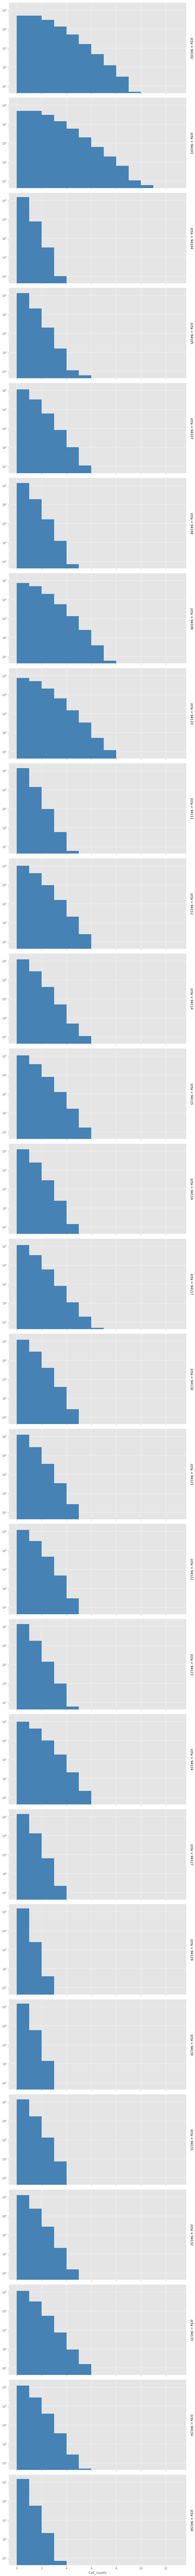

In [18]:
# width of the figure = size * aspect
g = sns.FacetGrid(ems_calls2, row="zcta", margin_titles=True, size = 5, aspect = 2)
plt.yscale('log')
g.map(plt.hist, "Call_counts", color="steelblue", bins=bins, lw=0)


## Statsmodels

In [19]:
from sklearn.model_selection import train_test_split

data = ems_calls2.copy()

data['zcta'] = data['zcta'].astype('category')

X = data[['zcta', 'year','month','day_of_month', 'hour_of_day', 
          'day_of_year', 'week_of_year', 'day_of_week', 'is_weekend']]

y = data[['Call_counts']]

# split the data into train, dev, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

# X_train, X_test, y_train, y_test 
#     = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val 
#     = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train.shape
y_train.shape

X_test.shape
y_test.shape


X_train.head()
y_train.head()

X_test.head()
y_test.head()

(2770616, 9)

(2770616, 1)

(1364632, 9)

(1364632, 1)

,zcta,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
2804763,94124,2005,8,25,20,237,34,3,False
1561945,94114,2003,9,13,5,256,37,5,True
915097,94108,2017,4,19,7,109,16,2,False
804212,94108,2004,8,25,2,238,35,2,False
2074750,94117,2009,10,6,5,279,41,1,False


,Call_counts
2804763,2
1561945,0
915097,0
804212,0
2074750,1


,zcta,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
1379598,94112,2000,5,17,7,138,20,2,False
2269734,94118,2014,7,12,16,193,28,5,True
888006,94108,2014,3,17,12,76,12,0,False
2477444,94122,2003,4,8,9,98,15,1,False
3152651,94129,2010,7,4,4,185,26,6,True


,Call_counts
1379598,0
2269734,0
888006,0
2477444,0
3152651,0


### Possion Regression

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse

formula = """Call_counts ~ zcta + year+ month + day_of_month 
                        + hour_of_day + day_of_year + week_of_year  
                        + day_of_week + is_weekend"""

# model data
mod_data = pd.concat([X_train, y_train], axis = 1)

mod1 = smf.glm(formula=formula, data=mod_data, family=sm.families.Poisson()).fit()

In [21]:
print( mod1.summary())
# print('Parameters: ', mod1.params)
# print('T-values: ', mod1.tvalues)
# print('fitted values: ', pd.DataFrame( mod1.fittedvalues) )
df_fitted = pd.DataFrame( mod1.fittedvalues)
df_fitted.head(5)
df_fitted.tail(5)

print("AIC: ",mod1.aic)
print("BIC: ", mod1.bic)
print("mu: ", mod1.mu )

# print("bse: ", mod1.bse)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Call_counts   No. Observations:              2770616
Model:                            GLM   Df Residuals:                  2770581
Model Family:                 Poisson   Df Model:                           34
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.7315e+06
Date:                Tue, 31 Oct 2017   Deviance:                   2.0135e+06
Time:                        15:29:59   Pearson chi2:                 2.86e+06
No. Iterations:                     7                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -73.2293      0.427   -171.444      0.000     -74.066     -72.392
zcta[T.94103]          0.030

,0
2804763,0.4716
1561945,0.1707
915097,0.1691
804212,0.0917
2074750,0.2613


,0
2961239,0.0620
3923815,0.2234
210755,0.9696
1104664,0.8052
1873416,0.1398


AIC:  3463125.83068
BIC:  -39086919.3206
mu:  [ 0.47161669  0.17071098  0.16909983 ...,  0.96963003  0.80515345
  0.13980955]


In [22]:
y_pred = mod1.predict(X_test)
y_pred.shape
y_test['Call_counts'].shape

mod1_mse = mse(y_pred, y_test['Call_counts'])


(1364632,)

(1364632,)

### Negative Binomial Regression

https://stats.idre.ucla.edu/stata/dae/zero-inflated-negative-binomial-regression/

There are excessive zeroes in the dataset! So I use zero inflated negative binomial regression


In [23]:
mod2 = smf.glm(formula=formula, data=mod_data, family=sm.families.NegativeBinomial()).fit()


In [24]:
print(mod2.summary())
print('Parameters: ', mod2.params)
print('T-values: ', mod2.tvalues)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Call_counts   No. Observations:              2770616
Model:                            GLM   Df Residuals:                  2770581
Model Family:        NegativeBinomial   Df Model:                           34
Link Function:                    log   Scale:                   0.81079467376
Method:                          IRLS   Log-Likelihood:            -1.7696e+06
Date:                Tue, 31 Oct 2017   Deviance:                   1.4870e+06
Time:                        15:31:03   Pearson chi2:                 2.25e+06
No. Iterations:                     7                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -70.7426      0.476   -148.500      0.000     -71.676     -69.809
zcta[T.94103]          0.022

In [25]:
data[:10]
mod1.fittedvalues[:10]

,zcta,Received_DtTm,Call_counts,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend
0,94102,2000-04-12 21:00:00,1,2000,4,12,21,103,15,2,False
1,94102,2000-04-12 22:00:00,1,2000,4,12,22,103,15,2,False
2,94102,2000-04-12 23:00:00,0,2000,4,12,23,103,15,2,False
3,94102,2000-04-13 00:00:00,0,2000,4,13,0,104,15,3,False
4,94102,2000-04-13 01:00:00,2,2000,4,13,1,104,15,3,False
5,94102,2000-04-13 02:00:00,2,2000,4,13,2,104,15,3,False
6,94102,2000-04-13 03:00:00,0,2000,4,13,3,104,15,3,False
7,94102,2000-04-13 04:00:00,0,2000,4,13,4,104,15,3,False
8,94102,2000-04-13 05:00:00,0,2000,4,13,5,104,15,3,False
9,94102,2000-04-13 06:00:00,1,2000,4,13,6,104,15,3,False


2804763    0.4716
1561945    0.1707
915097     0.1691
804212     0.0917
2074750    0.2613
2264900    0.2281
2629970    0.1154
2768651    0.2740
3025117    0.1128
1279966    0.0992
dtype: float64

In [26]:
y_pred = mod2.predict(X_test)
y_pred.shape
y_test['Call_counts'].shape

mod2_mse = mse(y_pred, y_test['Call_counts'])

print(mod2_mse)

(1364632,)

(1364632,)

0.341884548493


### Zero Inflated Poission

In [27]:
from statsmodels.miscmodels.count import PoissonZiGMLE

# Zero Inflated Poission Model
mod_zi_pos = PoissonZiGMLE.from_formula(formula=formula,data=data).fit()

C:\Anaconda3\envs\py35\lib\site-packages\statsmodels\miscmodels\count.py:249: RuntimeWarning:

overflow encountered in exp



KeyboardInterrupt: 

In [ ]:
print(mod_zi_pos.summary())

In [ ]:
from statsmodels.stats.api import anova_lm

table2 = anova_lm(mod1, mod2, test = "Chisq")
print(table2)

## Prediction

In [89]:
from datetime import datetime
from itertools import product

In [90]:
now = datetime.now()
today = now.strftime('%m/%d/%Y')
rng = pd.date_range(today, periods=24*30, freq='H')

zcta = data['zcta'].unique()
zcta

X_predict = pd.DataFrame(list(product(zcta, rng)))

X_predict.columns = ['zcta', 'Received_DtTm']

[94102, 94103, 94104, 94105, 94107, ..., 94131, 94132, 94133, 94134, 94158]
Length: 27
Categories (27, int64): [94102, 94103, 94104, 94105, ..., 94132, 94133, 94134, 94158]

In [91]:
X_predict.head()
X_predict.tail()
X_predict.info()
X_predict.describe(include='all')

,zcta,Received_DtTm
0,94102,2017-10-31 00:00:00
1,94102,2017-10-31 01:00:00
2,94102,2017-10-31 02:00:00
3,94102,2017-10-31 03:00:00
4,94102,2017-10-31 04:00:00


,zcta,Received_DtTm
19435,94158,2017-11-29 19:00:00
19436,94158,2017-11-29 20:00:00
19437,94158,2017-11-29 21:00:00
19438,94158,2017-11-29 22:00:00
19439,94158,2017-11-29 23:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 2 columns):
zcta             19440 non-null int64
Received_DtTm    19440 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 303.8 KB


,zcta,Received_DtTm
count,19440.0000,19440
unique,NaN,720
top,NaN,2017-11-02 11:00:00
freq,NaN,27
first,NaN,2017-10-31 00:00:00
last,NaN,2017-11-29 23:00:00
mean,94119.0741,NaN
std,12.4336,NaN
min,94102.0000,NaN
25%,94109.0000,NaN


In [92]:
X_predict['year'], X_predict['month'],  X_predict['day_of_month'], \
    X_predict['hour_of_day'], X_predict['day_of_year'], \
    X_predict['week_of_year'], X_predict['day_of_week'], X_predict['is_weekend'] = \
    zip(*X_predict['Received_DtTm'].map(lambda val: [val.year, val.month, val.day, val.hour, \
                                                val.dayofyear, val.week, val.weekday(), \
                                                val.weekday() in [5,6]]))

In [93]:
X_predict['zcta'] = X_predict['zcta'].astype('category')

X_predict = X_predict[['zcta', 'year','month','day_of_month', 'hour_of_day', 
          'day_of_year', 'week_of_year', 'day_of_week', 'is_weekend']]

In [94]:
X_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 9 columns):
zcta            19440 non-null category
year            19440 non-null int32
month           19440 non-null int32
day_of_month    19440 non-null int32
hour_of_day     19440 non-null int32
day_of_year     19440 non-null int32
week_of_year    19440 non-null int32
day_of_week     19440 non-null int32
is_weekend      19440 non-null bool
dtypes: bool(1), category(1), int32(7)
memory usage: 571.1 KB


In [95]:
y_pred2 = pd.DataFrame(mod2.predict(X_predict))
y_pred2.columns = ['Call_counts']
y_pred2.shape
y_pred2.head()
y_pred2.tail()


(19440, 1)

,Call_counts
0,1.1005
1,1.1315
2,1.1633
3,1.1961
4,1.2297


,Call_counts
19435,0.0626
19436,0.0644
19437,0.0662
19438,0.0680
19439,0.0699


In [96]:
df_pred = pd.concat([X_predict, y_pred2], axis = 1)
df_pred.head()

,zcta,year,month,day_of_month,hour_of_day,day_of_year,week_of_year,day_of_week,is_weekend,Call_counts
0,94102,2017,10,31,0,304,44,1,False,1.1005
1,94102,2017,10,31,1,304,44,1,False,1.1315
2,94102,2017,10,31,2,304,44,1,False,1.1633
3,94102,2017,10,31,3,304,44,1,False,1.1961
4,94102,2017,10,31,4,304,44,1,False,1.2297


In [97]:
DATA_DIR = './data'
FNAME = 'ems_calls_predict_mod2.csv' #'ems_calls_resampled.csv'
fname = os.path.join(DATA_DIR, FNAME)

df_pred.to_csv(fname, index= False, encoding = 'utf-8')